Lambda School Data Science

*Unit 2, Sprint 3, Module 2*

---


# Permutation & Boosting

You will use your portfolio project dataset for all assignments this sprint.

## Assignment

Complete these tasks for your project, and document your work.

- [ ] If you haven't completed assignment #1, please do so first.
- [ ] Continue to clean and explore your data. Make exploratory visualizations.
- [ ] Fit a model. Does it beat your baseline? 
- [ ] Try xgboost.
- [ ] Get your model's permutation importances.

You should try to complete an initial model today, because the rest of the week, we're making model interpretation visualizations.

But, if you aren't ready to try xgboost and permutation importances with your dataset today, that's okay. You can practice with another dataset instead. You may choose any dataset you've worked with previously.

The data subdirectory includes the Titanic dataset for classification and the NYC apartments dataset for regression. You may want to choose one of these datasets, because example solutions will be available for each.


## Reading

Top recommendations in _**bold italic:**_

#### Permutation Importances
- _**[Kaggle / Dan Becker: Machine Learning Explainability](https://www.kaggle.com/dansbecker/permutation-importance)**_
- [Christoph Molnar: Interpretable Machine Learning](https://christophm.github.io/interpretable-ml-book/feature-importance.html)

#### (Default) Feature Importances
  - [Ando Saabas: Selecting good features, Part 3, Random Forests](https://blog.datadive.net/selecting-good-features-part-iii-random-forests/)
  - [Terence Parr, et al: Beware Default Random Forest Importances](https://explained.ai/rf-importance/index.html)

#### Gradient Boosting
  - [A Gentle Introduction to the Gradient Boosting Algorithm for Machine Learning](https://machinelearningmastery.com/gentle-introduction-gradient-boosting-algorithm-machine-learning/)
  - _**[A Kaggle Master Explains Gradient Boosting](http://blog.kaggle.com/2017/01/23/a-kaggle-master-explains-gradient-boosting/)**_
  - [_An Introduction to Statistical Learning_](http://www-bcf.usc.edu/~gareth/ISL/ISLR%20Seventh%20Printing.pdf) Chapter 8
  - [Gradient Boosting Explained](http://arogozhnikov.github.io/2016/06/24/gradient_boosting_explained.html)
  - _**[Boosting](https://www.youtube.com/watch?v=GM3CDQfQ4sw) (2.5 minute video)**_

In [2]:
## As my sets are not yet ready for use on this assignment, I'm pulling in the SalesDF from Unit2 s1-m3,
## as it will provide practice with regression.

In [1]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Applied-Modeling/master/data/'
    !pip install category_encoders==2.*
    !pip install eli5

# If you're working locally:
else:
    DATA_PATH = '../data/'    

In [6]:
conda list

# packages in environment at C:\Users\SLightfoot\Anaconda3\envs\Unit2:
#
# Name                    Version                   Build  Channel
_py-xgboost-mutex         2.0                       cpu_0  
altair                    3.2.0                    py37_0    conda-forge
asn1crypto                1.2.0                    py37_0    conda-forge
astroid                   2.3.2                    py37_0    conda-forge
astropy                   3.2.3                    pypi_0    pypi
atomicwrites              1.3.0                    pypi_0    pypi
attrs                     19.3.0                     py_0    conda-forge
backcall                  0.1.0                      py_0    conda-forge
blas                      1.0                         mkl  
bleach                    3.1.0                      py_0    conda-forge
bokeh                     1.3.4                    py37_0    conda-forge
branca                    0.3.1                      py_0    conda-forge
ca-certificates         

In [5]:
import matplotlib.pyplot

ImportError: DLL load failed: The specified module could not be found.

In [3]:
import pandas as pd
import numpy as np
import category_encoders as ce
# import matplotlib.pyplot as plt
import eli5

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_absolute_error as meanAbErr
from sklearn.metrics import mean_squared_error as meanSqErr

from eli5.sklearn import PermutationImportance
from xgboost import XGBRegressor

In [14]:
# Import
df = pd.read_csv(DATA_PATH+'condos/NYC_Citywide_Rolling_Calendar_Sales.csv')

In [15]:
## REAL TALK HERE:
##     Doing a fair amount of copy/paste from 2-1-3 just to get going on today's assignment!

In [16]:
# Change column names: replace spaces with underscores
df.columns = [col.replace(' ', '_') for col in df]

# SALE_PRICE was read as strings.
# Remove symbols, convert to integer
df['SALE_PRICE'] = (
    df['SALE_PRICE']
    .str.replace('$','')
    .str.replace('-','')
    .str.replace(',','')
    .astype(int)
)

df['BOROUGH'] = df['BOROUGH'].astype(str)

top10 = df['NEIGHBORHOOD'].value_counts()[:10].index
df.loc[~df['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD'] = 'OTHER'

df['YEAR_BUILT'] = df['YEAR_BUILT'].ffill().astype(int)

df['SALE_DATE'] = pd.to_datetime(df['SALE_DATE'])

In [17]:
df['SALE_DATE'].describe()

count                   23040
unique                    120
top       2019-01-24 00:00:00
freq                      480
first     2019-01-01 00:00:00
last      2019-04-30 00:00:00
Name: SALE_DATE, dtype: object

In [19]:
train = df[df['SALE_DATE'] < pd.datetime(2019, 4, 1)]
test = df[df['SALE_DATE'] >= pd.datetime(2019, 4, 1)]
assert(len(train) + len(test) == len(df))

In [20]:
target = 'SALE_PRICE'
badObjCols = ['TAX_CLASS_AT_PRESENT', 'BUILDING_CLASS_AT_PRESENT', 
           'ADDRESS', 'APARTMENT_NUMBER', 'LAND_SQUARE_FEET',
           'BUILDING_CLASS_AT_TIME_OF_SALE', 'SALE_DATE', 'EASE-MENT']

features = train.columns.drop([target] + badObjCols)

In [21]:
features

Index(['BOROUGH', 'NEIGHBORHOOD', 'BUILDING_CLASS_CATEGORY', 'BLOCK', 'LOT',
       'ZIP_CODE', 'RESIDENTIAL_UNITS', 'COMMERCIAL_UNITS', 'TOTAL_UNITS',
       'GROSS_SQUARE_FEET', 'YEAR_BUILT', 'TAX_CLASS_AT_TIME_OF_SALE'],
      dtype='object')

In [22]:
train, val = train_test_split(train, train_size=0.8, test_size=0.2,
                              random_state=55)

In [62]:
X_train = train[features]
X_val = val[features]
X_test = test[features]

y_train = train[target]
y_val = val[target]
y_test = test[target]

In [63]:
y_baseline = [y_test.mean()] * len(y_test)

In [95]:
pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='mean'), 
    RandomForestRegressor(n_estimators=100, random_state=55, n_jobs=-2)
)

In [96]:
pipeline.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['BOROUGH', 'NEIGHBORHOOD',
                                      'BUILDING_CLASS_CATEGORY'],
                                drop_invariant=False, handle_missing='value',
                                handle_unknown='value',
                                mapping=[{'col': 'BOROUGH',
                                          'data_type': dtype('O'),
                                          'mapping': 3      1
4      2
1      3
2      4
5      5
NaN   -2
dtype: int64},
                                         {'col': 'NEIGHBORHOOD',
                                          'data_type': dtype('O'),
                                          'mapping': OTHER                       1
FLUSHING-NORTH              2
U...
                ('randomforestregressor',
                 RandomForestRegressor(bootstrap=True, criterion='mse',
                                       max_depth=None, max_featur

In [97]:
y_val_pred = pipeline.predict(X_val)
y_test_pred = pipeline.predict(X_test)

val_mae = meanAbErr(y_val, y_val_pred)
val_mse = meanSqErr(y_val, y_val_pred)
val_rmse = val_mse**.5
test_mae = meanAbErr(y_test, y_test_pred)
test_mse = meanSqErr(y_test, y_test_pred)
test_rmse = test_mse**.5

print(f'Validation Absolute Err: ${val_mae:,.0f}\nSqRt of MeanSqErr: ${val_rmse:,.0f}\n')
print(f'Test Absolute Err: ${test_mae:,.0f}\nSqRt of MeanSqErr: ${test_rmse:,.0f}\n')

Validation Absolute Err: $1,129,931
SqRt of MeanSqErr: $9,036,081

Test Absolute Err: $1,916,845
SqRt of MeanSqErr: $9,075,663



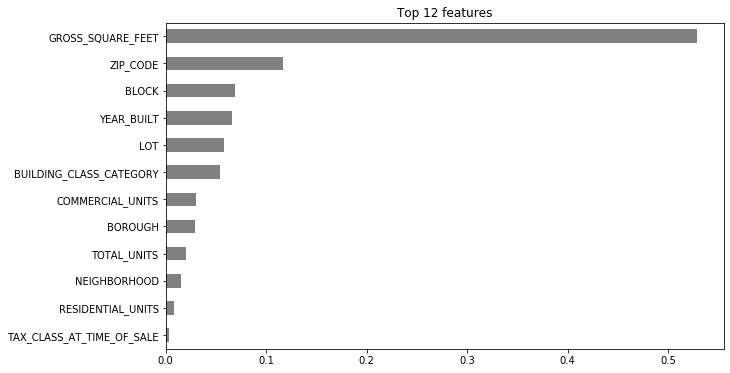

In [67]:
# Get feature importances
rf = pipeline.named_steps['randomforestregressor']
importances = pd.Series(rf.feature_importances_, X_train.columns)

n = len(features)
plt.figure(figsize=(10,n/2))
plt.title(f'Top {n} features')
importances.sort_values()[-n:].plot.barh(color='grey');

In [68]:
transformers = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='mean')
)

X_train_transformed = transformers.fit_transform(X_train)
X_val_transformed = transformers.transform(X_val)

model = RandomForestRegressor(n_estimators=100, random_state=55, n_jobs=-2)
model.fit(X_train_transformed, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-2,
                      oob_score=False, random_state=55, verbose=0,
                      warm_start=False)

In [69]:
permuter = PermutationImportance(
    model,
    n_iter=5, 
    random_state=55
)

permuter.fit(X_val_transformed, y_val)

PermutationImportance(cv='prefit',
                      estimator=RandomForestRegressor(bootstrap=True,
                                                      criterion='mse',
                                                      max_depth=None,
                                                      max_features='auto',
                                                      max_leaf_nodes=None,
                                                      min_impurity_decrease=0.0,
                                                      min_impurity_split=None,
                                                      min_samples_leaf=1,
                                                      min_samples_split=2,
                                                      min_weight_fraction_leaf=0.0,
                                                      n_estimators=100,
                                                      n_jobs=-2,
                                                      oob_score=False,
   

In [70]:
feature_names = X_val.columns.tolist()
pd.Series(permuter.feature_importances_, feature_names).sort_values(ascending=False)

GROSS_SQUARE_FEET            0.691751
ZIP_CODE                     0.123471
COMMERCIAL_UNITS             0.026719
TAX_CLASS_AT_TIME_OF_SALE    0.005574
RESIDENTIAL_UNITS            0.004775
TOTAL_UNITS                  0.003180
BOROUGH                      0.002390
BLOCK                        0.000176
LOT                          0.000057
NEIGHBORHOOD                -0.001153
BUILDING_CLASS_CATEGORY     -0.009919
YEAR_BUILT                  -0.015150
dtype: float64

In [71]:
feature_names = X_val.columns.tolist()

eli5.show_weights(
    permuter,
    top=None, # show permutation importances for all features
    feature_names=feature_names
)

Weight,Feature
0.6918 ± 0.0958,GROSS_SQUARE_FEET
0.1235 ± 0.1201,ZIP_CODE
0.0267 ± 0.0035,COMMERCIAL_UNITS
0.0056 ± 0.0010,TAX_CLASS_AT_TIME_OF_SALE
0.0048 ± 0.0014,RESIDENTIAL_UNITS
0.0032 ± 0.0032,TOTAL_UNITS
0.0024 ± 0.0087,BOROUGH
0.0002 ± 0.0077,BLOCK
0.0001 ± 0.0108,LOT
-0.0012 ± 0.0055,NEIGHBORHOOD


In [72]:
minimum_importance = 0.001
mask = permuter.feature_importances_ > minimum_importance
features_masked = X_train.columns[mask]
X_train_masked = X_train[features_masked]

In [75]:
X_val_masked = X_val[features_masked]
X_test_masked = X_test[features_masked]

pipeline2 = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='median'), 
    RandomForestRegressor(n_estimators=100, random_state=55, n_jobs=-2)
)

# Fit on train, score on val
pipeline2.fit(X_train_masked, y_train)

In [94]:
y_val_pred = pipeline2.predict(X_val_masked)
y_test_pred = pipeline2.predict(X_test_masked)

val_mae = meanAbErr(y_val, y_val_pred)
val_mse = meanSqErr(y_val, y_val_pred)
val_rmse = val_mse**.5
test_mae = meanAbErr(y_test, y_test_pred)
test_mse = meanSqErr(y_test, y_test_pred)
test_rmse = test_mse**.5

print(f'Validation Absolute Err: ${val_mae:,.0f}\nSqRt of MeanSqErr: ${val_rmse:,.0f}\n')
print(f'Test Absolute Err: ${test_mae:,.0f}\nSqRt of MeanSqErr: ${test_rmse:,.0f}\n')

Validation Absolute Err: $1,172,690
SqRt of MeanSqErr: $8,843,509

Test Absolute Err: $1,972,067
SqRt of MeanSqErr: $10,384,090



In [90]:
pipeline3 = make_pipeline(
    ce.OrdinalEncoder(), 
    XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=55, n_jobs=-2)
)

pipeline3.fit(X_train, y_train)

C:\Users\SLightfoot\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\SLightfoot\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['BOROUGH', 'NEIGHBORHOOD',
                                      'BUILDING_CLASS_CATEGORY'],
                                drop_invariant=False, handle_missing='value',
                                handle_unknown='value',
                                mapping=[{'col': 'BOROUGH',
                                          'data_type': dtype('O'),
                                          'mapping': 3      1
4      2
1      3
2      4
5      5
NaN   -2
dtype: int64},
                                         {'col': 'NEIGHBORHOOD',
                                          'data_type': dtype('O'),
                                          'mapping': OTHER                       1
FLUSHING-NORTH              2
U...
                              colsample_bylevel=1, colsample_bynode=1,
                              colsample_bytree=1, gamma=0,
                              importance_type='ga

In [92]:
y_val_pred = pipeline3.predict(X_val)
y_test_pred = pipeline3.predict(X_test)

val_mae = meanAbErr(y_val, y_val_pred)
val_mse = meanSqErr(y_val, y_val_pred)
val_rmse = val_mse**.5
test_mae = meanAbErr(y_test, y_test_pred)
test_mse = meanSqErr(y_test, y_test_pred)
test_rmse = test_mse**.5
print(f'Validation Absolute Err: ${val_mae:,.0f}\nSqRt of MeanSqErr: ${val_rmse:,.0f}\n')
print(f'Test Absolute Err: ${test_mae:,.0f}\nSqRt of MeanSqErr: ${test_rmse:,.0f}\n')

Validation Absolute Err: $1,293,050
SqRt of MeanSqErr: $9,922,563

Test Absolute Err: $1,744,663
SqRt of MeanSqErr: $7,376,954



In [1]:
encoder = ce.OrdinalEncoder()
X_train_encoded = encoder.fit_transform(X_train)
X_val_encoded = encoder.transform(X_val)

model = XGBRegressor(
    objective='reg:squarederror',
    n_estimators=1000, # <= 1000 trees, depends on early stopping
    max_depth=7,       # try deeper trees because of high cardinality categoricals
    learning_rate=0.5, # try higher learning rate
    n_jobs=-2
)

eval_set = [(X_train_encoded, y_train), 
            (X_val_encoded, y_val)]

model.fit(X_train_encoded, y_train, 
          eval_set=eval_set, 
          eval_metric='merror', 
          early_stopping_rounds=50)

NameError: name 'ce' is not defined